# 基于 Fashion MINST 的全连接模型

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 导入torchvision库
from torchvision import datasets, transforms
# 定义一个转换函数，将图像转换为张量（Tensor）
transformation = transforms.Compose([
                                transforms.ToTensor(),  # transforms.ToTensor()会将图像转换为张量，并且将像素值缩放到0-1之间，并且将channel放在第一维度上
                                # transforms.Normalize((0.5,), (0.5,))  # transforms.Normalize()会将图像的像素值进行标准化，即将像素值减去均值，然后除以标准差
])

# 从datasets模块中导入MNIST数据集
# 训练集
train_ds = datasets.FashionMNIST(
                          # 数据集的存储路径
                          'dataset/',
                          # 是否为训练集
                          train=True,
                          # 数据集的转换函数
                          transform=transformation,
                          # 是否下载数据集
                          download=True  
)
# 测试集
test_ds = datasets.FashionMNIST(
                          'dataset/',
                          train=False,
                          transform=transformation,
                          download=True  
)

In [3]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True) # 对dataset进行封装，将数据批量加载，batch_size为64，shuffle为True表示打乱数据集
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.liner_1 = nn.Linear(28*28, 120)    # 输入层到隐藏层，全连接层，超参数选择为120
        self.liner_2 = nn.Linear(120, 84)       # 隐藏层到隐藏层，超参数选择为84
        self.liner_3 = nn.Linear(84, 10)        # 隐藏层到输出层，分类数为10
    def forward(self, input):
        x = input.view(-1, 28*28)               # 将输入的图片展平，将channel维度去掉，将hight和width维度合并为一个维度 28*28
        x = F.relu(self.liner_1(x))             # 第一层，激活函数为ReLU
        x = F.relu(self.liner_2(x))             # 第二层，激活函数为ReLU
        logits = self.liner_3(x)                # 输出层，不使用激活函数，未激活的输出通常被称为logits
        return logits

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model = Model().to(device) # 将模型移动到GPU上实例化模型

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
# opt = torch.optim.Adam(model.parameters(), lr=0.001) # 优化器，Adam优化器，学习率为0.001
opt = torch.optim.SGD(model.parameters(), lr=0.001) # 优化器，SGD优化器，学习率为0.001

In [6]:
# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model = Model().to(device) # 将模型移动到GPU上实例化模型

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.SGD(model.parameters(), lr=0.001) # 优化器，SGD优化器，学习率为0.001
epochs = 50

# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)


Epoch: 0, Train Loss: 2.2520, Train Acc: 24.15%, Test Loss: 2.1985, Test Acc: 35.47%
Epoch: 1, Train Loss: 2.1169, Train Acc: 45.34%, Test Loss: 2.0147, Test Acc: 49.27%
Epoch: 2, Train Loss: 1.8683, Train Acc: 47.49%, Test Loss: 1.7118, Test Acc: 46.87%
Epoch: 3, Train Loss: 1.5611, Train Acc: 51.05%, Test Loss: 1.4318, Test Acc: 55.99%
Epoch: 4, Train Loss: 1.3253, Train Acc: 60.15%, Test Loss: 1.2424, Test Acc: 60.59%
Epoch: 5, Train Loss: 1.1676, Train Acc: 63.21%, Test Loss: 1.1145, Test Acc: 63.41%
Epoch: 6, Train Loss: 1.0567, Train Acc: 65.11%, Test Loss: 1.0214, Test Acc: 65.16%
Epoch: 7, Train Loss: 0.9736, Train Acc: 66.62%, Test Loss: 0.9502, Test Acc: 65.43%
Epoch: 8, Train Loss: 0.9103, Train Acc: 67.91%, Test Loss: 0.8951, Test Acc: 67.29%
Epoch: 9, Train Loss: 0.8608, Train Acc: 69.34%, Test Loss: 0.8525, Test Acc: 69.07%
Epoch: 10, Train Loss: 0.8215, Train Acc: 70.58%, Test Loss: 0.8185, Test Acc: 69.43%
Epoch: 11, Train Loss: 0.7898, Train Acc: 71.69%, Test Loss: 0.7

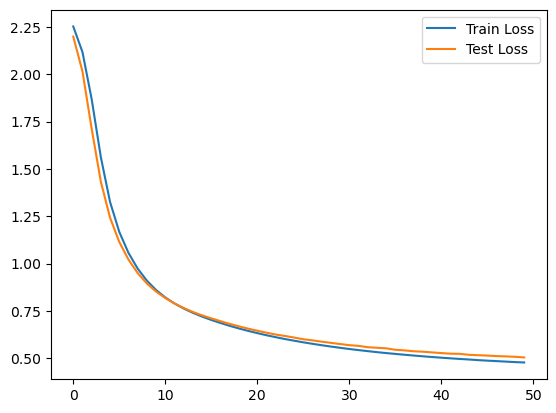

In [7]:
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), test_loss, label='Test Loss')
plt.legend()

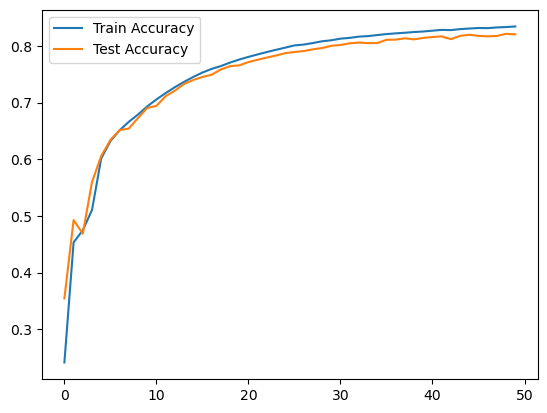

In [8]:
plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), test_acc, label='Test Accuracy')
plt.legend()